# Extra seminar: Recommendation systems

Этот практический семинар проведет вас через весь цикл создания рекомендательных систем. К концу семинара вы сможете:  
- Поймете основные концепции, такие как **коллаборативная фильтрация** и **матричная факторизация**.  
- Реализовывать алгоритмы, использующие как явную (`scikit-surprise`), так и неявную (`implicit`) обратную связь.  
- Научитесь оценивать и интерпретировать рекомендации для реальных сценариев.  

In [ ]:
!pip uninstall numpy

!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.11/dist-packages/numpy-1.26.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


In [ ]:
!pip install scikit-surprise implicit

In [ ]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip
    !unzip recsys.zip

--2025-03-17 19:49:16--  https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nzhinusoftcm/review-on-collaborative-filtering/master/recsys.zip [following]
--2025-03-17 19:49:16--  https://raw.githubusercontent.com/nzhinusoftcm/review-on-collaborative-filtering/master/recsys.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15312323 (15M) [application/zip]
Saving to: ‘recsys.zip’

recsys.zip          100%[===================>]  14.60M  --.-KB/s    in 0.09s   

2025-03-17 19:49:16 (164 MB/s) - ‘recsys.zip’ saved [

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from surprise import Dataset, SVD, KNNWithMeans, accuracy, Reader
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import precision_at_k
from scipy.sparse import csr_matrix

from recsys.datasets import ml1m, ml100k

## 1. Загрузка данных

In [ ]:
ratings, movies = ml100k.load()

Download data 100.2%
Successfully downloaded ml-100k.zip 4924029 bytes.
Unzipping the ml-100k.zip zip file ...


In [ ]:
ratings.head(10)

,userid,itemid,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3
5,1,6,5
6,1,7,4
7,1,8,1
8,1,9,5
9,1,10,3


In [ ]:
movies.head()

,itemid,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
len(ratings)

100000

- Колонка **userId** - идентификаторы пользователей сайта movielens;
- Колонка **movieId** - идентификаторы фильмов;
- Колонка **rating** - оценки фильмов пользователями по шкале от 1 до 5;
- Колонка **timestamp** - это время оценки фильма пользователем. Данный формат представления времени показывает, сколько секунд прошло с 1 января 1970 года.

Мы можем посмотреть, сколько уникальных значений находится в каждой из колонок.

In [ ]:
ratings.apply("nunique")

,0
userId,943
movieId,1682
rating,5
timestamp,49282


Посмотрим наглядно, как часто в датасете встречаются разные оценки:

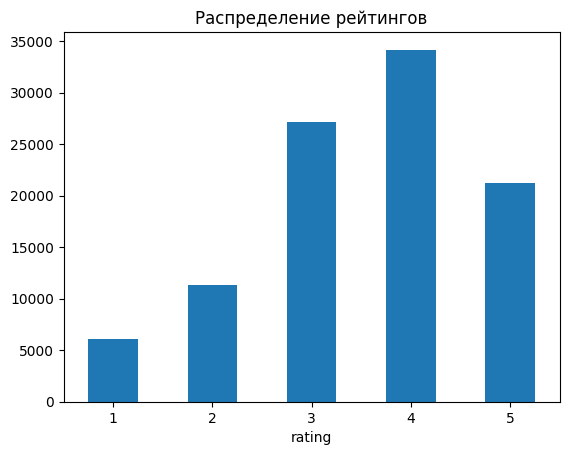

In [ ]:
ratings["rating"].value_counts().sort_index().plot.bar(title="Распределение рейтингов", rot=0);

## 2. EDA

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
users_ratings = ratings.groupby("userid")["rating"].count()

print("Mean:   ", users_ratings.mean())
print("Std:    ", users_ratings.std())
print("Median: ", users_ratings.median())

Mean:    106.04453870625663
Std:     100.93174276633502
Median:  65.0


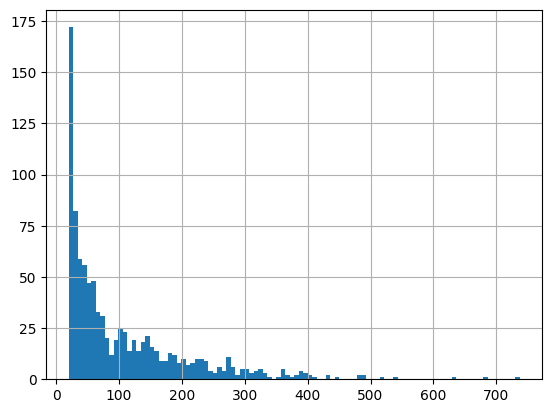

In [ ]:
users_ratings.hist(bins=100);

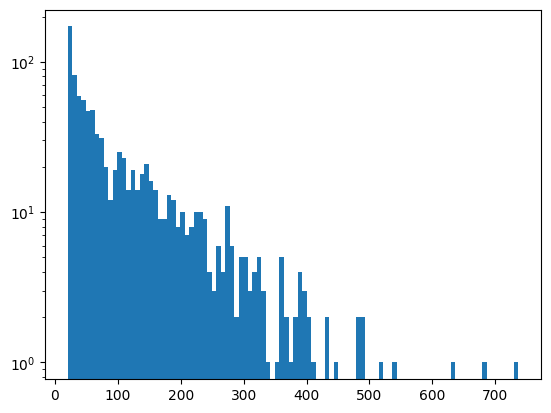

In [ ]:
plt.hist(users_ratings, bins=100, log=True);

Гистограмма имеет длинный хвост справа. Большая часть пользователей поставила менее 50 оценок. В среднем один человек ставит 80 оценок при достаточно большом стандартном отклонении величиной в 75 оценок. Это говорит о том, что поведение пользователей очень разнится, но значительная часть пользователей имеет только несколько единиц оцененных фильмов.

In [ ]:
movies_ratings = ratings.groupby("itemid")["rating"].count()

print("Mean:   ", movies_ratings.mean())
print("Std:    ", movies_ratings.std())
print("Median: ", movies_ratings.median())

Mean:    59.45303210463734
Std:     80.38384561004855
Median:  27.0


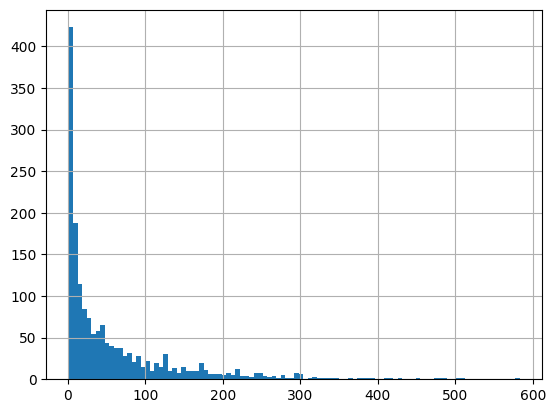

In [ ]:
movies_ratings.hist(bins=100);

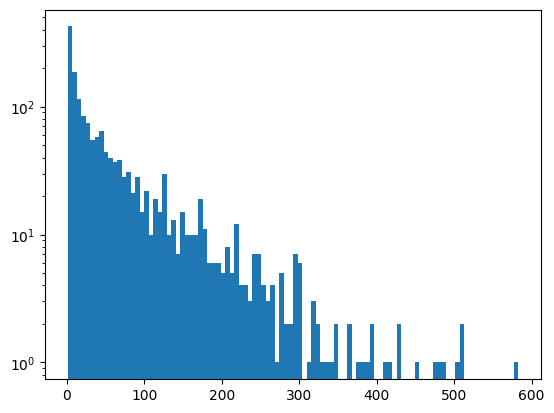

In [ ]:
plt.hist(movies_ratings, bins=100, log=True);

## 3. Построение моделей

Сначала, закодируем юзеров и айтемы:

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings["userid"].unique())
    items = sorted(ratings["itemid"].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    # encode userids and itemids
    ratings.userid = uencoder.transform(ratings.userid.tolist())
    ratings.itemid = iencoder.transform(ratings.itemid.tolist())

    return ratings, uencoder, iencoder

In [ ]:
ratings, uencoder, iencoder = ids_encoder(ratings)

Разделим на трейн и тест выборки:

In [ ]:
grouped = ratings.groupby('userid')

In [ ]:
grouped.head()

,userid,itemid,rating
0,0,0,5
1,0,1,3
2,0,2,4
3,0,3,3
4,0,4,3
...,...,...,...
99832,942,1,5
99833,942,8,3
99834,942,10,4
99835,942,11,5


In [ ]:
ratings_train = pd.DataFrame(columns=ratings.columns)
ratings_valid = pd.DataFrame(columns=ratings.columns)

for _, group in grouped:
    train_group, valid_group = train_test_split(group, test_size=0.2, random_state=123)
    ratings_train = pd.concat([ratings_train, train_group])
    ratings_valid = pd.concat([ratings_valid, valid_group])

assert(len(ratings['userid'].unique()) == len(ratings_train['userid'].unique()))
assert(len(ratings_valid['userid'].unique()) == len(ratings_train['userid'].unique()))

In [ ]:
reader = Reader(rating_scale=(1, 5))

### User2user

In [ ]:
user_user = KNNWithMeans(k=50, sim_options={'name': 'cosine', 'user_based': True})
user_user.fit(Dataset.load_from_df(ratings_train[['userid', 'itemid', 'rating']], reader).build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.


### Item2item

In [ ]:
item_item = KNNWithMeans(k=50, sim_options={'name': 'cosine', 'user_based': False})
item_item.fit(Dataset.load_from_df(ratings_train[['userid', 'itemid', 'rating']], reader).build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.


### ALS

In [ ]:
train_sparse = csr_matrix((np.ones(len(ratings_train), dtype=np.float32),
                         (ratings_train['userid'].astype(np.int32), ratings_train['itemid'].astype(np.int32))))
model_als = AlternatingLeastSquares(factors=50)
model_als.fit(train_sparse.T)

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0014142990112304688 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
def get_recommendations(user_id, model_type='als', n=10):
    user_code = uencoder.transform([user_id])

    if model_type == 'als':
        items, _ = model_als.recommend(user_code[0], train_sparse[user_code[0]], N=n)
    elif model_type == 'user_user':
        testset = [(user_id, item, None) for item in ratings['itemid'].unique()]
        predictions = user_user.test(testset)
        items = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
        items = [int(pred.iid) for pred in items]
    elif model_type == 'item_item':
        testset = [(user_id, item, None) for item in ratings['itemid'].unique()]
        predictions = item_item.test(testset)
        items = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
        items = [int(pred.iid) for pred in items]

    recommendations = pd.DataFrame({'itemid': iencoder.inverse_transform(items)})
    return recommendations.merge(movies, on='itemid')

In [ ]:
print("Топ-10 рекомендаций ALS:")
print(get_recommendations(1, 'als'))

print("\nТоп-10 рекомендаций u2u:")
print(get_recommendations(1, 'user_user'))

print("\nТоп-10 рекомендаций i2i:")
print(get_recommendations(1, 'item_item'))

Топ-10 рекомендаций ALS:
   itemid                               title
0     561  Mary Shelley's Frankenstein (1994)
1     868             Hearts and Minds (1996)
2     417             Parent Trap, The (1961)
3     592                   True Crime (1995)
4     648               Quiet Man, The (1952)
5     653                Touch of Evil (1958)
6     864          My Fellow Americans (1996)
7     751          Tomorrow Never Dies (1997)
8     622        Swiss Family Robinson (1960)
9     387        Age of Innocence, The (1993)

Топ-10 рекомендаций u2u:
   itemid                                              title
0    1398                                        Anna (1996)
1    1463                                   Boys, Les (1997)
2    1467               Saint of Fort Washington, The (1993)
3    1536                               Aiqing wansui (1994)
4    1599                      Someone Else's America (1995)
5    1642                           Some Mother's Son (1996)
6    1653  Enter

In [ ]:
testset = list(zip(ratings_valid['userid'], ratings_valid['itemid'], ratings_valid['rating']))
print("User-User RMSE:", accuracy.rmse(user_user.test(testset)))
print("Item-Item RMSE:", accuracy.rmse(item_item.test(testset)))

RMSE: 0.9486
User-User RMSE: 0.9485600630251899
RMSE: 0.9350
Item-Item RMSE: 0.9350304476308873
